In [ ]:
#| default_exp segmentation.core

# segmentation core

> API details.

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
#TODO: optimize imports
from fastai.vision.all import *
from polvo.core import *

In [ ]:
data_dir = Path.home()

In [ ]:
data_dir

Path('/home/lgvaz')

TODOs:
- [x] compare original images
- [ ] resized images
- [x] augmented images
- [x] look at a single class of images (in whales, are they in the same water?)

In [ ]:
data_dir = untar_data(URLs.CAMVID_TINY)

In [ ]:
data_dir.ls()

(#3) [Path('/home/lgvaz/.fastai/data/camvid_tiny/codes.txt'),Path('/home/lgvaz/.fastai/data/camvid_tiny/images'),Path('/home/lgvaz/.fastai/data/camvid_tiny/labels')]

In [ ]:
image_files = get_image_files(data_dir/'images')

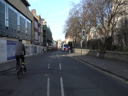

In [ ]:
image_file = image_files[0]
PILImage.create(image_file)

<AxesSubplot:>

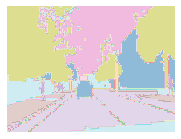

In [ ]:
mask_files = get_image_files(data_dir/'labels')
mask_file = mask_files[0]
PILMask.create(mask_file).show()

In [ ]:
mask_file

Path('/home/lgvaz/.fastai/data/camvid_tiny/labels/0001TP_008670_P.png')

In [ ]:
image_file

Path('/home/lgvaz/.fastai/data/camvid_tiny/images/0016E5_08155.png')

In [ ]:
def image2mask(image_file):
    return (image_file.parent.parent/f'labels/{image_file.stem}_P').with_suffix('.png')

In [ ]:
x_pipe = [PILImage.create]
y_pipe = [image2mask, PILMask.create]

splits = RandomSplitter(seed=42)(image_files)

x_tl = TfmdLists(image_files, x_pipe)
y_tl = TfmdLists(image_files, y_pipe)
dss = Datasets(image_files, [x_pipe, y_pipe], splits=splits)

<AxesSubplot:>

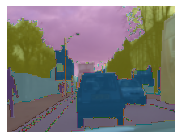

In [ ]:
dss.show(dss[1])

In [ ]:
codes = (data_dir/'codes.txt').read_text().strip('\n').split('\n')

In [ ]:
#|export
class SegmentationExplorer:
    def __init__(self, x_tl, y_tl, label_id2name):
        self.x_tl = x_tl
        self.y_tl = y_tl
        
        label_stats = []

        for item_idx, y in enumerate(y_tl):
            labels, counts = np.unique(y, return_counts=True)
            total = counts.sum()
            label_stats.extend([{'item_idx': item_idx,
                                 'label_id': l,
                                 'pct': c / total,
                                 'count': c,
                                 'label': label_id2name[l]} 
                                for l, c in zip(labels, counts)])
        
        grouped_y = pd.DataFrame(label_stats)
        grouped_y = grouped_y.groupby("label_id").agg({'label': 'first',
                                                       'item_idx': list,
                                                       'pct': list,
                                                       'count': sum}).reset_index()
        grouped_y["n_samples"] = grouped_y.item_idx.str.len()
        grouped_y = grouped_y.sort_values("count", ascending=False).reset_index(drop=True)
        self.grouped_y = grouped_y

    # TODO: Most common pixels and most common samples
    def most_common(self):
        "Return a dataframe ordered by most common classes."
        return self.grouped_y

    def show_label_id(self, id, slice_=slice(None)):
        # TODO: can we also pick the class name to show?
        idx = self.grouped_y[self.grouped_y["label_id"] == id].index[0]
        return self.show_most_common(idx=idx, slice_=slice_)
    
    def show_label(self, label, slice_=slice(None)):
        return self.show_label_id(self.label2id[label], slice_=slice_)

    def show_most_common(self, idx: int, slice_=slice(None)):
        idxs = self.grouped_y.iloc[idx].item_idx
        idxs = idxs[slice_]
        
        images = [self.x_tl[i] for i in idxs]
        shows = [image.show for image in images]
        xmax, ymax = np.max([image.size for image in images], axis=0)
        
        return image_grid(shows, xmax=xmax, ymax=ymax)
    
    @classmethod
    def from_datasets(cls, dss, label_id2name):
        return cls(dss.tls[0], dss.tls[1], label_id2name)

In [ ]:
exp = SegmentationExplorer.from_datasets(dss, codes)

In [ ]:
exp.most_common()

label_id              label  \
0         17               Road   
1          4           Building   
2         21                Sky   
3         26               Tree   
4         19           Sidewalk   
5          5                Car   
6         30               Void   
7         10       LaneMkgsDriv   
8         31               Wall   
9          9              Fence   
10         8        Column_Pole   
11        16         Pedestrian   
12        22     SUVPickupTruck   
13        29     VegetationMisc   
14         2          Bicyclist   
15        12          Misc_Text   
16        27          Truck_Bus   
17        14        OtherMoving   
18        24       TrafficLight   
19        15       ParkingBlock   
20        18       RoadShoulder   
21        20         SignSymbol   
22         6    CartLuggagePram   
23         1            Archway   
24         7              Child   
25        13  MotorcycleScooter   
26         0             Animal   
27        11    LaneMkgsNonDriv   
28         3             Bridge   
29        23        TrafficCone   

                                                                                                                                                                                                                                                                                                                                                                                                  item_idx  \
0   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
1       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
2   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
3                                                 [0, 1, 2, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 98, 99]   
4           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
5                                 [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
6       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3

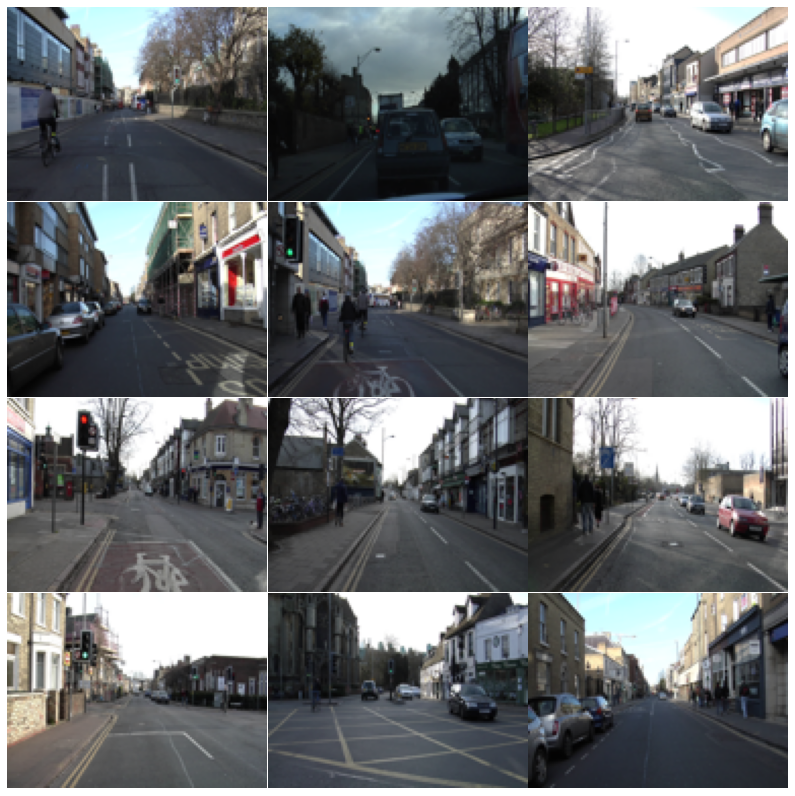

(<Figure size 1008x1152 with 24 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid>)

In [ ]:
exp.show_most_common(0, slice_=slice(0, 12))

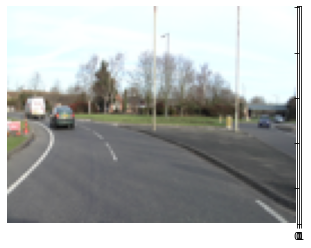

(<Figure size 1008x288 with 6 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid>)

In [ ]:
exp.show_label_id(23)

In [ ]:
exp.most_common()

label_id              label  \
0         17               Road   
1          4           Building   
2         21                Sky   
3         26               Tree   
4         19           Sidewalk   
5          5                Car   
6         30               Void   
7         10       LaneMkgsDriv   
8         31               Wall   
9          9              Fence   
10         8        Column_Pole   
11        16         Pedestrian   
12        22     SUVPickupTruck   
13        29     VegetationMisc   
14         2          Bicyclist   
15        12          Misc_Text   
16        27          Truck_Bus   
17        14        OtherMoving   
18        24       TrafficLight   
19        15       ParkingBlock   
20        18       RoadShoulder   
21        20         SignSymbol   
22         6    CartLuggagePram   
23         1            Archway   
24         7              Child   
25        13  MotorcycleScooter   
26         0             Animal   
27        11    LaneMkgsNonDriv   
28         3             Bridge   
29        23        TrafficCone   

                                                                                                                                                                                                                                                                                                                                                                                                  item_idx  \
0   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
1       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
2   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
3                                                 [0, 1, 2, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 98, 99]   
4           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
5                                 [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]   
6       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3

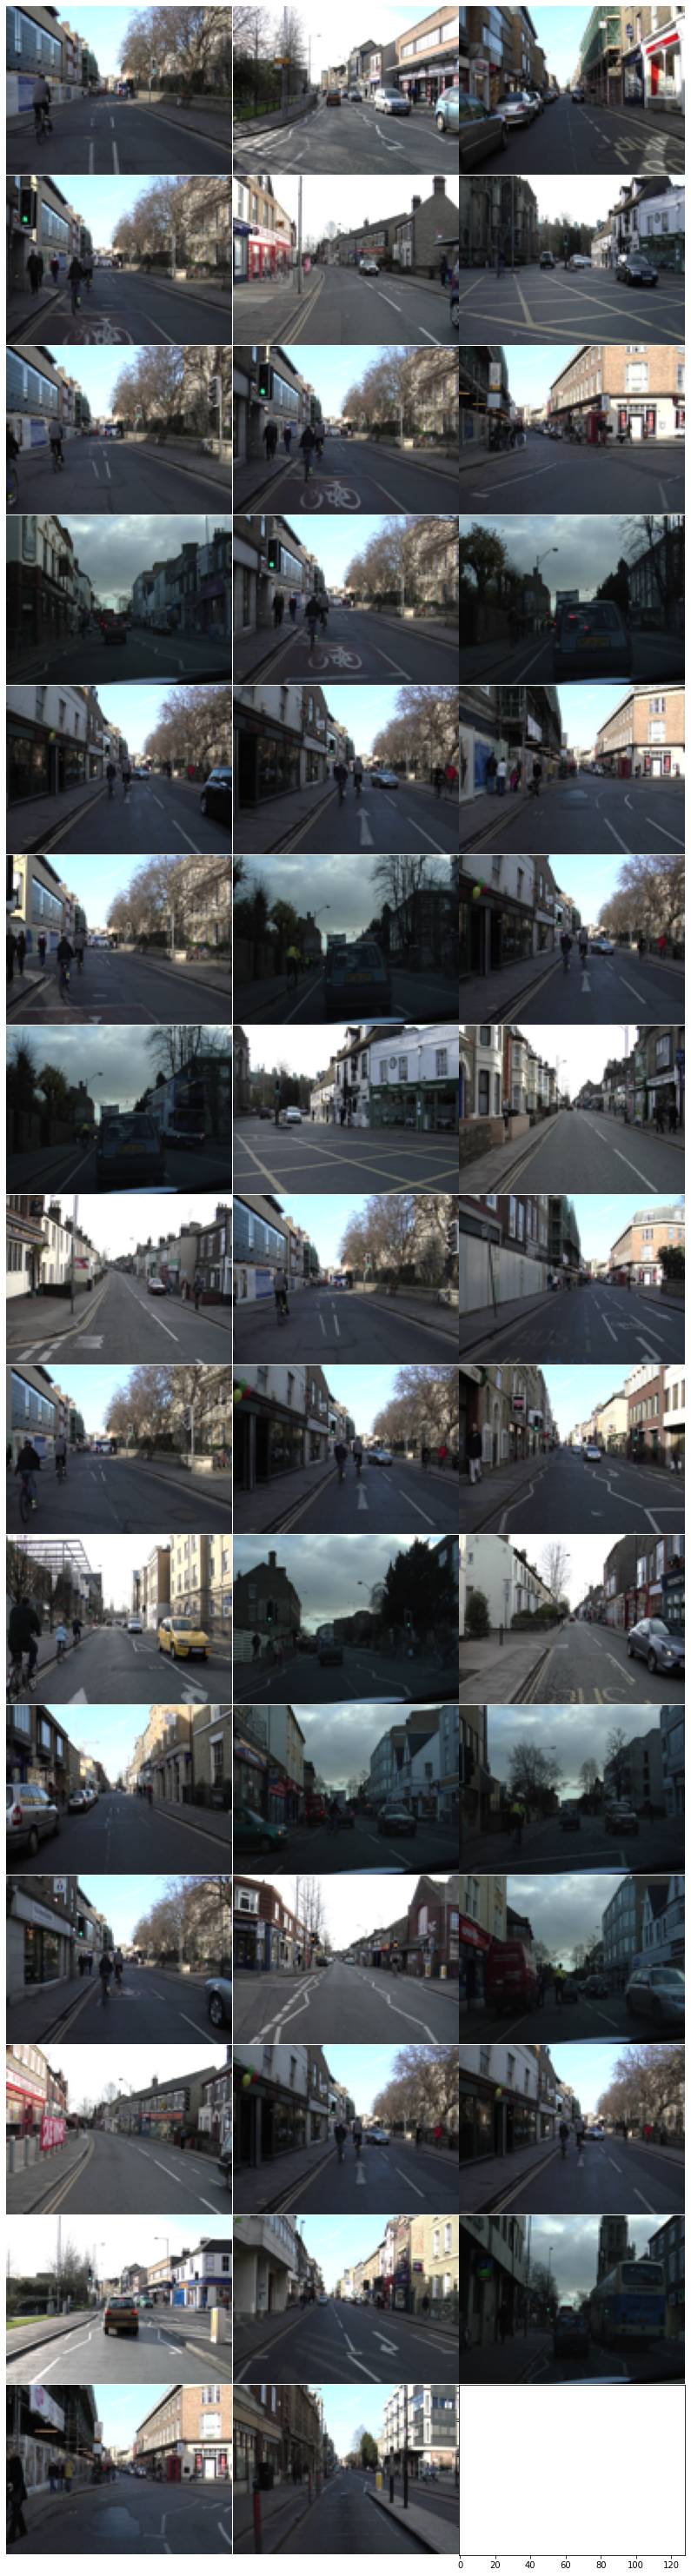

(<Figure size 1008x4320 with 90 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid>)

In [ ]:
exp.show_label_id(2)

## TODO: Test working!

In [ ]:
# after_item = [ToTensor(), Resize(500), AddMaskCodes(codes)]
# after_batch = [IntToFloatTensor(), *aug_transforms(size=300, min_scale=0.75, max_rotate=150)]
# dls = dss.dataloaders(32, after_item=after_item, after_batch=after_batch, num_workers=0)

In [ ]:
# show_tfms(dls.train, unique_idx=2)

In [ ]:
#| hide
# from nbdev import nbdev_export
# nbdev_export()